In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from EegHelper import EegDataPoint, EegDataset

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [2]:
#Update as needed when data is elsewhere
all_raw_data = glob.glob('./MindBigData-Imagenet-IN/MindBigData-Imagenet/*.csv')

In [3]:
#The format of the file is important, as it contains infromation about its label
print(all_raw_data[0])
print(len(all_raw_data))

./MindBigData-Imagenet-IN/MindBigData-Imagenet/MindBigData_Imagenet_Insight_n01776313_12356_1_494.csv
14012


In [4]:
#This is done on every data point in the following loop.
single_data_raw = pd.read_csv(all_raw_data[0], header=None).T #Read the file
single_data_raw.columns=single_data_raw.iloc[0] #The column names are sitting in the first row
raw_data = single_data_raw.iloc[65:, :] #Cuts a) the first line (column names) and then the next hals second (64 samples)
raw_data.head()

,AF3,AF4,T7,T8,Pz
65,4317.435897,4279.487179,4280.0,4262.051282,4236.410256
66,4312.820513,4273.846154,4275.384615,4246.666667,4231.794872
67,4291.282051,4244.615385,4248.717949,4205.128205,4209.74359
68,4277.435897,4240.0,4244.615385,4215.897436,4216.923077
69,4270.769231,4258.974359,4257.948718,4256.410256,4227.692308


In [5]:
def load_file(path):
    single_data_raw = pd.read_csv(path, header=None).T #Read file through panda
    single_data_raw.columns=single_data_raw.iloc[0]    #Reconfigure
    raw_data = single_data_raw.iloc[65:, :]            #Cut the first 64 samples (0.5 seconds) as this has been done in other research due to lag.
    if raw_data.shape[0] < 320:                        #Not enough samples. We want 320
        return None
    else:
        raw_data = raw_data.iloc[0:320]                #Return first 320 samples
        
    return np.array(raw_data).T

Load all the np array representations. This block will go through every path (eeg reading), convert it to a dataframe, crop as needed, and finally convert to data point object

In [6]:
all_points=[] #This will be a list of EegDataPoint
all_labels=set() #This will be a list of string (all unique labels)
for path in all_raw_data: #Remove/place a slice to work on full/partial set
    result = load_file(path) #np array
    path = path.replace('\\', '/') #Windows moment. Replace backslashes just in case
    if type(result) is np.ndarray: #If its not, the data was too short
        label = path.split('/')[3] 
        label = label.split('_')[3]
        all_labels.add(label)
        all_points.append(EegDataPoint(result, label)) #Custom object to keep track of label, and data.

all_points = np.array(all_points)
all_labels=list(all_labels)

print("Point raw data shape:", all_points[0].raw_data.shape)
print("Shape of point list:", all_points.shape)

Point raw data shape: (320, 5)
Shape of point list: (13405,)


The data needs to be filtered for low-frequency and high-frequency signal, which is often resultant from environmental/muscle noise in scalp EEG and otherwise is not generally the focus of analyses. Low-pass and high-pass filtering allows for noise below and above a certain frequency to remain in the data. 

This can done using the MNE command raw.filter( ), and you must specify what you want your band cut-offs to be. Typically, and depending on your planned analyses, filtering will be set around 1 and 50 Hertz. 3-30 BECAUSE WE CARE ABOUT THETA, BETA, ALPHA BANDS. THESE FALL IN THE RANGE OF 3-30 HZ

Bandpass filtering will also have the effect of smoothing out the raw data, and typically looks different than raw data to the naked eye.


The recommendation for setting the low-pass corner frequency at 1/3x
 
 of the desired sample rate is a fairly safe rule of thumb based on the default settings in raw.filter() (which are different from the filter settings used inside the raw.resample() method). If you use a customized lowpass filter (specifically, if your transition bandwidth is wider than 0.5× the lowpass cutoff), downsampling to 3× the lowpass cutoff may still not be enough to avoid aliasing, and MNE-Python will not warn you about it (because the raw.info object only keeps track of the lowpass cutoff, not the transition bandwidth). 

In [7]:
"""
We will loop through every data point and call the cleaning method.
"""
for point in all_points:
    point.clean(1, 30)    #We want 3-30 so multiply 3 by 1/3

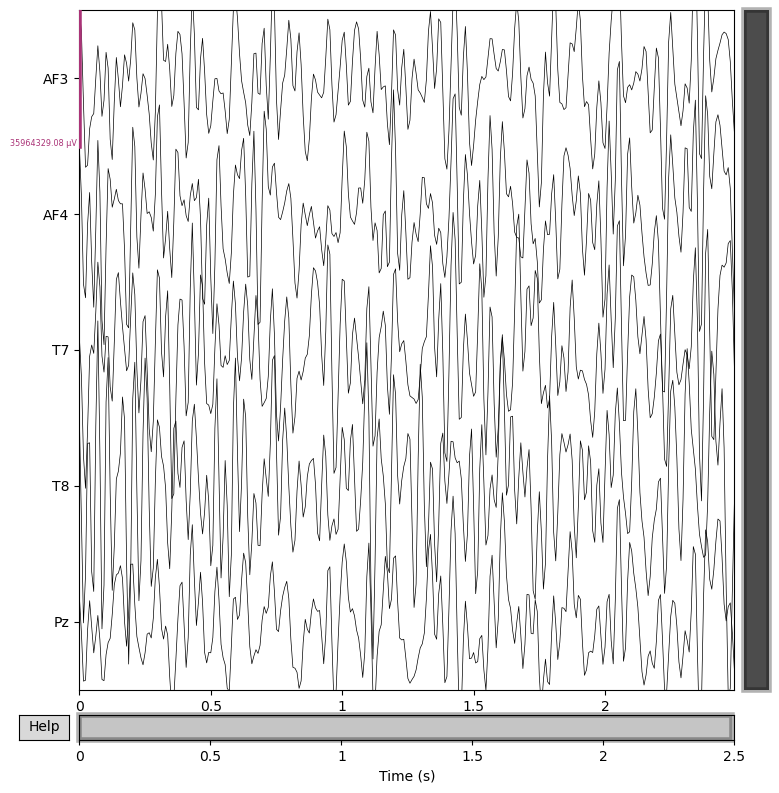

In [8]:
#Quick visual representation of the time series
all_points[0].mne_object.plot(scalings='auto');

Training moment

In [9]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from Old.EegClassifier import EegClassifierModel
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader

In [10]:
print(len(all_labels))
num_features = len(all_labels)

569


In [11]:
#Build the dataset. When we ask for an element we wil recieve raw data and also tensor of expected output
dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True) #Split ohbjects

Now, we setup dataloaders and build the model

In [12]:
batch_size = 16

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

model = EegClassifierModel(
    num_classes=num_features, 
    num_channels=5,
    timesteps=320, 
    hidden_size=4000, 
)

In [13]:
from tqdm.notebook import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)
print("If device is cuda, ensure that you set model.device")

n_epoch = 20
final_accuracy = 0.0

assert(batch_size < len(train))  #Check so that if working on subset of data, we don't break

model.to(device=device)
model.device = device            #If not set, everything will be on cpu

optomizer = Adam(model.parameters(), lr=0.001)
loss_function=nn.CrossEntropyLoss()

for epoch in range(n_epoch):

    print(f"Epoch {epoch+1}/{n_epoch}")

    model.train()

    train_accuracy = 0.0
    train_loss = 0.0

    for eegs, labels in tqdm(train_dataloader):
        
        eegs = eegs.to(device)
        labels = labels.to(device)
        optomizer.zero_grad()

        output=model(eegs)
        loss = loss_function(output, labels.squeeze(2))
        loss.backward()
        optomizer.step()

        train_loss += loss.cpu().data*eegs.size(0)
        _, prediction = torch.max(output.data, 1)

        train_accuracy += int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/len(train)
    train_loss=train_loss/len(train)
    
    print("Epoch Accuracy:", train_accuracy)
    print("Epoch Loss:", train_loss, '\n')

print("Final Accuracy:", final_accuracy)


Running on: cpu
If device is cuda, ensure that you set model.device
Epoch 1/20


  0%|          | 0/671 [00:00<?, ?it/s]